In [1]:
# # A fit with BAT.jl
#
# In this example we show how to bring the PDF parametrisation and
# forward model together with `BAT.jl` to perform a fit of simulated data.
# This fit is a work in progress and just a starting point for verification
# of the method.

In [2]:
using Pkg
Pkg.activate("../docs")

In [3]:
using BAT, DensityInterface
using PartonDensity
using QCDNUM
using Plots, Random, Distributions, ValueShapes, ParallelProcessingTools
using StatsBase, LinearAlgebra
using DelimitedFiles

gr(fmt=:png);

In [4]:
counts_obs_ep = readdlm("/Users/AllenCCaldwell/F2/PartonDensity/eP.dat") 
counts_obs_em = readdlm("/Users/AllenCCaldwell/F2/PartonDensity/eM.dat") 
nbins = size(counts_obs_ep)[1]

153

In [5]:
#ENV["JULIA_DEBUG"] = "BAT"

┌ Info: Valence λ:
│   pdf_params.λ_u = 0.8136406276819578
│   pdf_params.λ_d = 0.9144341352398601
└ @ Main In[6]:9
┌ Info: Momenta:
│   (pdf_params.θ[1], pdf_params.θ[2], pdf_params.θ[3], pdf_params.θ[4]) = (0.27990743831249726, 0.15461058730731392, 0.2913253322774652, 0.18187482140794864)
└ @ Main In[6]:10


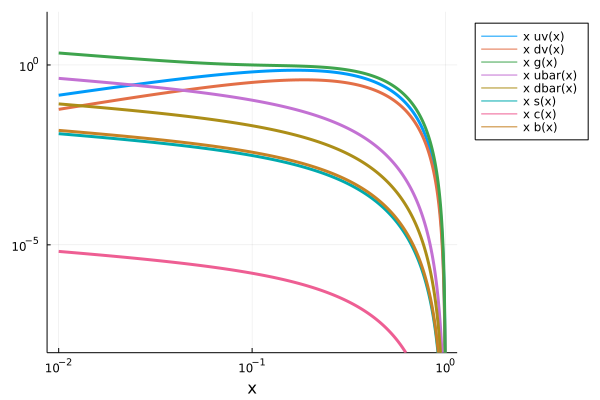

In [6]:
# ### Specify the input PDFs
#
# See the *Input PDF parametrisation and priors* example for more information on the
# definition of the input PDFs.

pdf_params = DirichletPDFParams(K_u=4.0, K_d=4.0, λ_g1=1.2, λ_g2=-0.4, K_g=4.0,
                                λ_q=-0.4, weights=[6., 3., 9., 4.0, 2.,1., 0.2, 0.2, 0.1]);
# replace weights with θ to specify the momentum fractions directly
@info "Valence λ:" pdf_params.λ_u pdf_params.λ_d
@info "Momenta:" pdf_params.θ[1],pdf_params.θ[2],pdf_params.θ[3],pdf_params.θ[4]
plot_input_pdfs(pdf_params)

In [7]:
# ### Go from PDFs to counts in ZEUS detector bins
#
# Given the input PDFs, we can then evolve, calculate the cross sections, and fold through
# the ZEUS transfer matrix to get counts in bins. Here, we make use of some simple helper
# functions to do so. For more details, see the *Forward model* example.

# first specify QCDNUM inputs
qcdnum_grid = QCDNUMGrid(x_min=[1.0e-3, 1.0e-1, 5.0e-1], x_weights=[1, 2, 2], nx=100,
                         qq_bounds=[1.0e2, 3.0e4], qq_weights=[1.0, 1.0], nq=50, spline_interp=3)
qcdnum_params = QCDNUMParameters(order=2, α_S=0.118, q0=100.0, grid=qcdnum_grid,
                                 n_fixed_flav=5, iqc=1, iqb=1, iqt=1, weight_type=1);


In [8]:
# now SPLINT and quark coefficients
splint_params = SPLINTParameters();
quark_coeffs = QuarkCoefficients();

In [9]:
# initialise QCDNUM
#forward_model_init(qcdnum_grid, qcdnum_params, splint_params)
forward_model_init_sysErr(qcdnum_grid, qcdnum_params, splint_params)

0.00019953
0.00016954
0.00019447
1.7525000000000006e-5
1.7525000000000006e-5
1.7525000000000006e-5
0.002478736000000001


In [10]:
# run forward model 
counts_pred_ep, counts_pred_em = forward_model(pdf_params, qcdnum_params,
    splint_params, quark_coeffs);

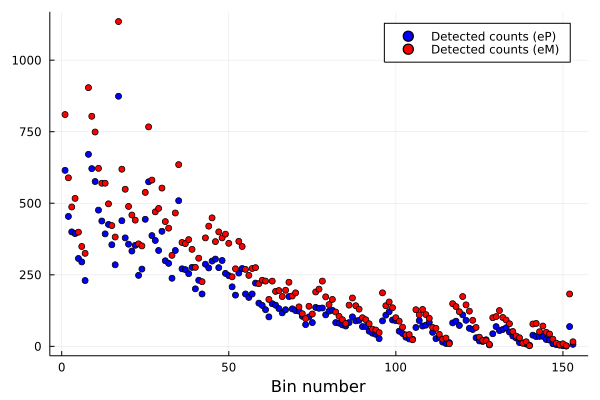

In [11]:
# Plot the data
scatter(1:nbins, counts_obs_ep, label="Detected counts (eP)", color="blue")
scatter!(1:nbins, counts_obs_em, label="Detected counts (eM)", color="red")
plot!(xlabel="Bin number")

In [12]:
savefig("/Users/AllenCCaldwell/F2/Dirichlet-DataFit/data-sysrun-priors-tight.png")

In [13]:
# store in array
obs_data = Dict{String, Any}()
obs_data["nbins"] = nbins;
obs_data["counts_obs_ep"] = counts_obs_ep;
obs_data["counts_obs_em"] = counts_obs_em;

In [14]:
# ## Fit the data

In [15]:
prior = NamedTupleDist(
    θ = Dirichlet([34.,17.,22.,22.,2,2,1,1,0.5]),
    K_u = Truncated(Normal(3.5, 0.5), 2., 5.),
    K_d = Truncated(Normal(3.5, 0.5), 2., 5.),
    λ_g1 = Uniform(1., 2.),
    λ_g2 = Uniform(-0.5, -0.1),
    K_g =  Truncated(Normal(4., 1.5), 2., 5.),
    λ_q = Uniform(-0.5, -0.1),
    Beta1 =  Truncated(Normal(0, 1), -5, 5),
    Beta2 =  Truncated(Normal(0, 1), -5, 5),
    beta0_1=  Truncated(Normal(0, 1), -5, 5), 
    beta0_2=   Truncated(Normal(0, 1), -5, 5),    
    beta0_3= Truncated(Normal(0, 1), -5, 5), 
    beta0_4=  Truncated(Normal(0, 1), -5, 5), 
    beta0_5=  Truncated(Normal(0, 1), -5, 5), 
    beta0_6=  Truncated(Normal(0, 1), -5, 5), 
    beta0_7=  Truncated(Normal(0, 1), -5, 5), 
    beta0_8=   Truncated(Normal(0, 1), -5, 5)
);

In [16]:
# The likelihood is similar to that used in the *input PDF parametrisation* example.
# We start by accessing the current parameter set of the sampler's iteration,
# then running the forward model to get the predicted counts and comparing to
# the observed counts using a simple Poisson likelihood.
#
# The `@critical` macro is used because `forward_model()` is currently not thread safe, so
# this protects it from being run in parallel.

In [17]:
likelihood = let d = obs_data

    counts_obs_ep = d["counts_obs_ep"]
    counts_obs_em = d["counts_obs_em"]
    nbins = d["nbins"]

    logfuncdensity(function (params)

            pdf_params = DirichletPDFParams(K_u=params.K_u, K_d=params.K_d, λ_g1=params.λ_g1, λ_g2=params.λ_g2,
                                            K_g=params.K_g, λ_q=params.λ_q, θ=params.θ)

            #Ensure u-valence weight > d-valence weight
            if params.θ[2] > params.θ[1]

                return -Inf

            end
          
            ParErrs = [params.beta0_1,params.beta0_2,params.beta0_3,params.beta0_4,
                params.beta0_5,params.beta0_6,params.beta0_7,params.beta0_8]
            
            counts_pred_ep, counts_pred_em = @critical  forward_model_sysErr(pdf_params, 
                qcdnum_params, splint_params, quark_coeffs,ParErrs );
 #           counts_pred_ep, counts_pred_em = @critical forward_model(pdf_params,
 #               qcdnum_params, splint_params, quark_coeffs);

            ll_value = 0.0
            for i in 1:nbins

                if counts_pred_ep[i] < 0
                   @debug "counts_pred_ep[i] < 0, setting to 0" i counts_pred_ep[i]
                   counts_pred_ep[i] = 0
                end

                if counts_pred_em[i] < 0
                   @debug "counts_pred_em[i] < 0, setting to 0" i counts_pred_em[i]
                   counts_pred_em[i] = 0
                end
                
                counts_pred_ep[i] =counts_pred_ep[i]*(1+0.018*params.Beta1)
                counts_pred_em[i] =counts_pred_em[i]*(1+0.018*params.Beta2)

                ll_value += logpdf(Poisson(counts_pred_ep[i]), counts_obs_ep[i])
                ll_value += logpdf(Poisson(counts_pred_em[i]), counts_obs_em[i])
            end

            return ll_value
    end)
end

LogFuncDensity(var"#1#2"{Int64, Matrix{Float64}, Matrix{Float64}}(153, [810.0; 589.0; … ; 183.0; 16.0], [615.0; 454.0; … ; 69.0; 7.0]))

In [18]:
# We can now run the MCMC sampler. We will start by using the
# Metropolis-Hastings algorithm as implemented in `BAT.jl`.
# To demonstrate, we run a short chain of 10^3 iterations, which
# should take around 10 minutes.

In [19]:
posterior = PosteriorDensity(likelihood, prior);
mcalg = MetropolisHastings(proposal=BAT.MvTDistProposal(10.0))
convergence = BrooksGelmanConvergence(threshold=1.3);
burnin = MCMCMultiCycleBurnin(max_ncycles=50);

samples = bat_sample(posterior, MCMCSampling(mcalg=mcalg, nsteps=5*10^5, nchains=2)).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/AllenCCaldwell/.julia/packages/BAT/3nu45/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 2 viable MCMC chain(s).
└ @ BAT /Users/AllenCCaldwell/.julia/packages/BAT/3nu45/src/samplers/mcmc/chain_pool_init.jl:68
┌ Info: Selected 2 MCMC chain(s).
└ @ BAT /Users/AllenCCaldwell/.julia/packages/BAT/3nu45/src/samplers/mcmc/chain_pool_init.jl:186
┌ Info: Begin tuning of 2 MCMC chain(s).
└ @ BAT /Users/AllenCCaldwell/.julia/packages/BAT/3nu45/src/samplers/mcmc/multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 2 chains, 0 tuned, 0 converged.
└ @ BAT /Users/AllenCCaldwell/.julia/packages/BAT/3nu45/src/samplers/mcmc/multi_cycle_burnin.jl:69
┌ Info: MCMC Tuning cycle 2 finished, 2 chains, 2 tuned, 2 converged.
└ @ BAT /Users/AllenCCaldwell/.julia/packages/BAT/3nu45/src/samplers/mcmc/multi_cycle_burnin.jl:69
┌ Info: MCMC tuning of 2 chains successful after 2 cycle(s).
└ @ BAT /Users/AllenCCaldwe

In [20]:
# Let's save the result for further analysis

In [21]:
import HDF5
bat_write("/Users/AllenCCaldwell/F2/Dirichlet-DataFit/Data-Dirichlet-sysrun-priors-tight.h5", samples)

In [22]:
# ## Analysing the results
#
# First, let's load our simulation inputs and results

In [23]:
# We can check some diagnostics using built in `BAT.jl`, such as the
# effective sample size shown below

In [24]:
bat_eff_sample_size(unshaped.(samples))[1]

25-element Vector{Float64}:
 3779.233364556223
 3537.416206495775
 4044.9841711676763
 4566.085784507876
 2632.2628589896517
 4221.87375415969
 3674.0926157824415
 2560.9230909276266
 3066.180870127174
 3848.1953792614604
 4100.741629741896
 3691.5280773381646
 4530.099692653855
 4984.052592911916
 3754.8953396151583
 5127.430765128344
 5769.756280377758
 5297.500018931499
 5669.042454149561
 4200.9018964382685
 4652.895247872587
 3527.353935352878
 4392.489139246017
 4569.200353974195
 5012.975743757635

In [25]:
open("report.md", "w") do io
  show(io, MIME"text/markdown"(), bat_report(samples))
end
open("report.txt", "w") do io
   show(io, MIME"text/plain"(), bat_report(samples))
end